Found 2339 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Class names: ['AFRICAN LEOPARD', 'CARACAL', 'CHEETAH', 'CLOUDED LEOPARD', 'JAGUAR', 'LIONS', 'OCELOT', 'PUMA', 'SNOW LEOPARD', 'TIGER']
Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.1109 - loss: 2.3204
Epoch 1: saving model to training_1/cp.weights.h5
74/74 ━━━━━━━━━━━━━━━━━━━━ 19s 243ms/step - accuracy: 0.1111 - loss: 2.3191 - val_accuracy: 0.2400 - val_loss: 2.0409
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.2304 - loss: 2.0097
Epoch 2: saving model to training_1/cp.weights.h5
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 237ms/step - accuracy: 0.2310 - loss: 2.0085 - val_accuracy: 0.3600 - val_loss: 1.7177
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.4111 - loss: 1.5360
Epoch 3: saving model to training_1/cp.weights.h5
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 241ms/step - accuracy: 0.4115 - loss: 1.5351 - val_accuracy: 0.5

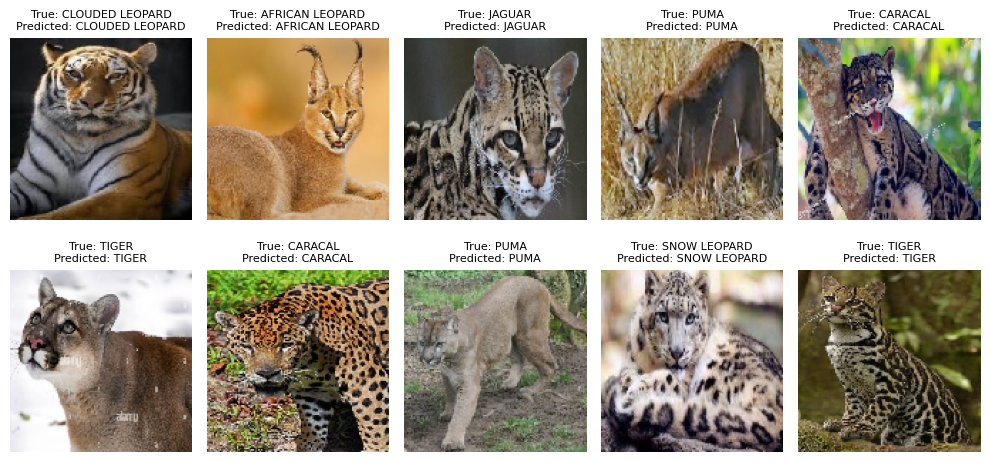

In [20]:
#import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define paths to the dataset directories
train_path = './archive/train'
test_path = './archive/test'
valid_path = './archive/valid'

# Define image size and batch size
img_height, img_width = 128, 128  # Adjust these values if your images have a different size
batch_size = 32

# Define ImageDataGenerators for loading and augmenting the data
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for each set
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Get the class names
class_names = list(train_generator.class_indices.keys())

# Display class names
print("Class names:", class_names)

# Build the model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(class_names), activation='softmax'),
])

initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.98, staircase=True
)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_path = "training_1/cp.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=valid_generator,
                    callbacks=[cp_callback])


# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

# Make predictions on the test dataset
# Collect true labels and model predictions
true_labels = []
predicted_labels = []
class_names = test_generator.class_indices.keys()    
class_names = list(class_names)
num_batches = len(train_generator)
for i in range(10):
    x_batch, y_batch = train_generator[i]
    predictions = model.predict(x_batch)
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(predictions, axis=1))


true_class_labels = [class_names[i] for i in true_labels]
predicted_class_labels = [class_names[i] for i in predicted_labels]

# Plot true labels and predicted labels
plt.figure(figsize=(10, 5))
num_samples_to_display = min(10, len(x_batch))  # Display up to 10 samples or less if available
for i in range(num_samples_to_display):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f'True: {true_class_labels[i]}\nPredicted: {predicted_class_labels[i]}', fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

